<a href="https://colab.research.google.com/github/mahshadmoradi/DL/blob/main/BERT_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT with Adapter

In [ ]:
%%capture
!pip install datasets
!pip install -qq adapters datasets
!pip install accelerate -U

In [ ]:
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


- This notebook only used 1 GPU ...

##Data preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File paths
train_file = "/content/drive/MyDrive/DL-project/Dataset/subtaskB_train.jsonl"
dev_file = "/content/drive/MyDrive/DL-project/Dataset/subtaskB_dev.jsonl"

# Load the dataset
dataset = load_dataset("json", data_files={"train": train_file, "dev": dev_file})

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

def create_balanced_dataset(dataset, target_size_percentage):

    train_dataset = dataset['train']
    df = pd.DataFrame(train_dataset)
    subset_size = int(target_size_percentage * len(df))
    label_counts = df['label'].value_counts(normalize=True)
    # Calculate the number of samples to take from each label for a balanced subset
    samples_per_label = (label_counts * subset_size).round().astype(int)
    # Sample the data
    subset_dfs = [df[df['label'] == label].sample(n=samples, random_state=42) for label, samples in samples_per_label.items()]
    # Concatenate the per-label subsets into one DataFrame
    balanced_subset_df = pd.concat(subset_dfs)
    # Shuffle the dataset
    balanced_subset_df = balanced_subset_df.sample(frac=1, random_state=42).reset_index(drop=True)

    final_dataset = DatasetDict({
    'train': Dataset.from_pandas(balanced_subset_df),
    'dev': dataset['dev'] # Dev remains unchanged
    })

    return final_dataset

In [ ]:
print(dataset["train"][199])  # Print an entry

{'text': "Gelato is a delicious and refreshing frozen dessert that is perfect on hot summer days or any time when you want a tasty treat. If you love the flavors of chocolate and hazelnut, then this Mocha Nutella Gelato recipe is sure to be a hit! Making gelato is not difficult, and with a few simple steps, you can create a creamy and flavorful dessert that your family and friends will love. Follow the steps below to learn how to make mocha Nutella gelato.\n\nIngredients:\n\n- 2 cups whole milk\n- 2 cups heavy cream\n- 1 cup sugar\n- 8 egg yolks\n- 1 cup Nutella\n- 1 cup heavy cream\n- 1/2 tbsp instant coffee\n- 8 oz semi-sweet chocolate, chopped\n\nInstructions:\n\n1. Separate egg yolks from the whites, and place the egg yolks in a bowl.\n\n2. Pour milk and heavy cream into a saucepan and heat over medium heat until it starts to simmer.\n\n3. While the milk and cream mixture is heating, place the egg yolks and sugar in a separate bowl and whisk until the mixture becomes light and fluf

In [ ]:
dataset_1 = create_balanced_dataset(dataset, 0.01)
dataset_1["train"].num_rows

710

In [ ]:
from datasets import DatasetDict

def prepare_dataset(dataset, tokenizer, max_seq_length):

    def encode_batch(batch):
        """Encodes a batch of input data using the model tokenizer."""
        return tokenizer(batch["text"], add_special_tokens=True, padding='max_length',
                         truncation=True, max_length=max_seq_length, return_tensors="pt")

    # Encode the input data
    dataset = dataset.map(encode_batch, batched=True)

    # The transformers model expects the target class column to be named "labels"
    dataset = dataset.rename_column("label", "labels")

    # Transform to pytorch tensors and only output the required columns
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return dataset

##Model

In [ ]:
learning_rate = 1e-4
num_classes = 6
max_seq_length = 128
label_list = list(range(6))
batch_size = 32
epochs = 4

In [ ]:
from transformers import RobertaTokenizer

model_name = 'roberta-large'
adapter_name = "SubtaskB"

tokenizer = RobertaTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [ ]:
print(len(dataset_1["train"]))

710


In [ ]:
from transformers import RobertaConfig
from adapters import AutoAdapterModel

config = RobertaConfig.from_pretrained(model_name, num_labels=num_classes)

In [ ]:
def BertWithAdapter():

    model = AutoAdapterModel.from_pretrained(model_name, config=config).to(device)
    # Add a new adapter
    model.add_adapter(adapter_name)

    model.set_active_adapters = adapter_name

    # Add a matching classification head
    model.add_classification_head(adapter_name, num_labels=num_classes, overwrite_ok=True)
    # Activate the adapter
    model.train_adapter(adapter_name)

    return model

In [ ]:
import numpy as np
from transformers import TrainingArguments, EvalPrediction
from adapters import AdapterTrainer

training_args = TrainingArguments(
    learning_rate=learning_rate,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
    evaluation_strategy="epoch",  # Perform evaluation at the end of each epoch
    logging_strategy="epoch",  # Log training loss at the end of each epoch
)

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    acc = (preds == p.label_ids).mean()
    f1 = f1_score(p.label_ids, preds, average='weighted')  # eventhough its balanced
    return {"acc": acc, "f1": f1}

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
metrics_list = []

##Percent 1

In [ ]:
dataset_1 = create_balanced_dataset(dataset, 0.01)
dataset_1 = prepare_dataset(dataset_1, tokenizer, max_seq_length)

Map:   0%|          | 0/710 [00:00<?, ? examples/s]

In [ ]:
model_1 = BertWithAdapter()

Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['heads.default.3.bias', 'heads.SubtaskB.1.bias', 'heads.SubtaskB.4.bias', 'heads.SubtaskB.4.weight', 'roberta.pooler.dense.bias', 'heads.SubtaskB.1.weight', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_1 = AdapterTrainer(
    model=model_1,
    args=training_args,
    train_dataset=dataset_1["train"],
    eval_dataset=dataset_1["dev"],
    compute_metrics=compute_metrics,
)

In [ ]:
print("Percent 1 : ")

# Start the timer
start_time = time.time()

trainer_1.train()

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total duration
formatted_time = format_time(total_time)
print(f"Training and evaluation time: {formatted_time} ")

Percent 1 : 


Epoch,Training Loss,Validation Loss,Acc,F1
1,1.798000,1.740375,0.288333,0.155327
2,1.610800,1.346946,0.529667,0.463936
3,1.339100,1.225279,0.517333,0.469569
4,1.209400,1.170268,0.567667,0.520689


Training and evaluation time: 0:07:13 


In [ ]:
eval_result_1 = trainer_1.evaluate()

# Access the accuracy and F1 score from the result
accuracy = eval_result_1['eval_acc']
f1 = eval_result_1['eval_f1']

metrics_list.append({'accuracy': accuracy, 'f1': f1})

In [ ]:
print(metrics_list[3])
# print(eval_result['eval_runtime'])

{'accuracy': 0.5676666666666667, 'f1': 0.5206889033767863}


##Percent 5

In [ ]:
dataset_5 = create_balanced_dataset(dataset, 0.05)
dataset_5 = prepare_dataset(dataset_5, tokenizer, max_seq_length)

Map:   0%|          | 0/3552 [00:00<?, ? examples/s]

In [ ]:
model_5 = BertWithAdapter()

Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['heads.default.3.bias', 'heads.SubtaskB.1.bias', 'heads.SubtaskB.4.bias', 'heads.SubtaskB.4.weight', 'roberta.pooler.dense.bias', 'heads.SubtaskB.1.weight', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_5 = AdapterTrainer(
    model=model_5,
    args=training_args,
    train_dataset=dataset_5["train"],
    eval_dataset=dataset_5["dev"],
    compute_metrics=compute_metrics,
)

In [ ]:
print("Percent 5 : ")

# Start the timer
start_time = time.time()

trainer_5.train()

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total duration
formatted_time = format_time(total_time)
print(f"Training and evaluation time: {formatted_time} ")

Percent 5 : 


Epoch,Training Loss,Validation Loss,Acc,F1
1,0.382700,1.560778,0.551000,0.554585
2,0.266700,1.757870,0.632000,0.593855
3,0.202800,1.851554,0.592000,0.569685
4,0.149000,1.876854,0.600667,0.581771


Training and evaluation time: 0:16:46 


In [ ]:
eval_result_5 = trainer_5.evaluate()

# Access the accuracy and F1 score from the result
accuracy = eval_result_5['eval_acc']
f1 = eval_result_5['eval_f1']

metrics_list.append({'accuracy': accuracy, 'f1': f1})

In [ ]:
print(metrics_list[2])
# print(eval_result['eval_runtime'])

{'accuracy': 0.6006666666666667, 'f1': 0.5817705705736689}


## Percent 10

In [ ]:
dataset_10 = create_balanced_dataset(dataset, 0.10)
dataset_10 = prepare_dataset(dataset_10, tokenizer, max_seq_length)

Map:   0%|          | 0/7102 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
model_10 = BertWithAdapter()

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['heads.default.3.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_10 = AdapterTrainer(
    model=model_10,
    args=training_args,
    train_dataset=dataset_10["train"],
    eval_dataset=dataset_10["dev"],
    compute_metrics=compute_metrics,
)

In [ ]:
print("Percent 10 : ")

# Start the timer
start_time = time.time()

trainer_10.train()

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total duration
formatted_time = format_time(total_time)
print(f"Training and evaluation time: {formatted_time} ")

Percent 10 : 


Epoch,Training Loss,Validation Loss,Acc,F1
1,1.132500,1.360031,0.565333,0.543808
2,0.430400,1.615767,0.614667,0.562843
3,0.267500,1.642729,0.632667,0.603913
4,0.206600,1.759756,0.632333,0.600057


Training and evaluation time: 0:28:37 


In [ ]:
eval_result_10 = trainer_10.evaluate()

# Access the accuracy and F1 score from the result
accuracy = eval_result_10['eval_acc']
f1 = eval_result_10['eval_f1']

metrics_list.append({'accuracy': accuracy, 'f1': f1})

In [ ]:
print(metrics_list[0])
# print(eval_result['eval_runtime'])

{'accuracy': 0.6323333333333333, 'f1': 0.600057344113328}


##Percent 50

In [ ]:
dataset_50 = create_balanced_dataset(dataset, 0.50)
dataset_50 = prepare_dataset(dataset_50, tokenizer, max_seq_length)

Map:   0%|          | 0/35512 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
model_50 = BertWithAdapter()

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['heads.default.3.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_50 = AdapterTrainer(
    model=model_50,
    args=training_args,
    train_dataset=dataset_50["train"],
    eval_dataset=dataset_50["dev"],
    compute_metrics=compute_metrics,
)

In [ ]:
print("Percent 50 : ")

# Start the timer
start_time = time.time()

trainer_50.train()

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total duration
formatted_time = format_time(total_time)
print(f"Training and evaluation time: {formatted_time} ")

Percent 50 : 


Epoch,Training Loss,Validation Loss,Acc,F1
1,0.474300,1.902104,0.616000,0.587916
2,0.172700,1.994240,0.721667,0.668203
3,0.119900,2.090635,0.706667,0.675417
4,0.087600,2.377817,0.700000,0.664237


Training and evaluation time: 2:02:51 


In [ ]:
eval_result_50 = trainer_50.evaluate()

# Access the accuracy and F1 score from the result
accuracy = eval_result_50['eval_acc']
f1 = eval_result_50['eval_f1']

metrics_list.append({'accuracy': accuracy, 'f1': f1})

In [ ]:
print(metrics_list[0])
# print(eval_result['eval_runtime'])

{'accuracy': 0.7, 'f1': 0.6642366563077035}


##Results

In [ ]:
accuracies = [56.77, 60.07, 63.23, 70.00]
f1_scores = [52.07, 58.18, 60.00, 66.42]

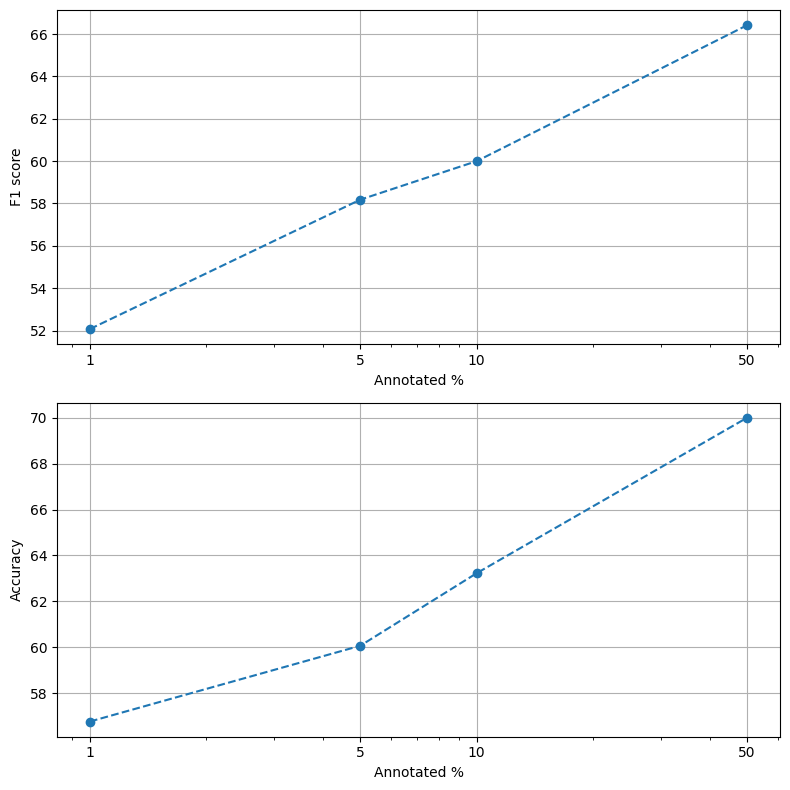

In [ ]:
ps = [1, 5, 10, 50]

# Creating two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot F1 Scores
ax1.plot(ps, f1_scores, 'o--', label='BERT')
ax1.set_xscale('log')  # Logarithmic scale
ax1.set_xticks(ps)  # Set the ticks to be at the percentages
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Format the ticks as scalar (default log format)
ax1.set_xlabel('Annotated %')
ax1.set_ylabel('F1 score')
# ax1.set_title('(a) 2ON')
ax1.grid(True)  # Add grid for better readability

# Plot Accuracy
ax2.plot(ps, accuracies, 'o--', label='BERT')
ax2.set_xscale('log')  # Logarithmic scale
ax2.set_xticks(ps)  # Set the ticks to be at the percentages
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Format the ticks as scalar (default log format)
ax2.set_xlabel('Annotated %')
ax2.set_ylabel('Accuracy')
ax2.grid(True)  # Add grid for better readability

# Adjust subplot layout
plt.tight_layout()
plt.show()